In [141]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os

rng = np.random.default_rng() # the Random Generator used throughout the script
DEBUG_VARIABLES = False # debug variables
SAVE_FIGURES = False # save figures for latex
DISPLAY_FIGURES = True # display figures in notebook

In [142]:
###########################################################
# Utilities
###########################################################

class Figure:
    def __init__(self, title, xlabel, ylabel, x, ys, legends, filename):
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        for y in ys:
            plt.plot(x,y)
        plt.legend(legends, loc = "best", frameon = False)
        self.filename = filename
        self.save_figure_or_continue()
    def save_figure_or_continue(self):
        plt.show
        plt.savefig(self.filename + ".png", bbox_inches = "tight")
        if SAVE_FIGURES: 
            plt.savefig("../latex/figures/" + self.filename + ".png", bbox_inches = "tight")
        plt.close()

def display_figures():
    filelist=os.listdir()
    for file in filelist:
        if file.endswith(".png"):
            display.display(display.Image(file))

def delete_figures():
    filelist=os.listdir()
    for file in filelist:
        if file.endswith(".png"):
            os.remove(file)

def debug_variable(value):
    """ A utility to debug an object's inner properties in Jupyter
    """
    if DEBUG_VARIABLES:
        return value
    
def unique_random(size = 1):
    """ Returns a list -of a given size- of unique random floats in the range of 0 <= x <= 1
    """
    floats = []
    floats_seen = set()
    for i in range(size):
        new_float = rng.random()
        while new_float in floats_seen:
            new_float = rng.random()
        floats_seen.add(new_float)
        floats.append(new_float)
    return floats

class MAB:
    def __init__(self, total_time, bandits_num):
        self.total_time = total_time # horizon T
        self.bandits_num = bandits_num # number of armed bandits k
        self.rng = np.random.default_rng()
        self._set_bounds()

    def _set_bounds(self):
        """ Sets lower and upper bounds for each bandit's rewards according to assignment's requirements
        """
        self.lower_bounds = np.zeros(self.bandits_num)
        self.upper_bounds = np.ones(self.bandits_num)
        self.expected_mu = np.zeros(self.bandits_num) # the expected mu of each arm

        bounds = unique_random(2*self.bandits_num) # pools together both lower (a_i) and upper (b_i) bounds
        for i in range(0, 2*self.bandits_num, 2):
            self.lower_bounds[i//2] = min(bounds[i:i+2])
            self.upper_bounds[i//2] = max(bounds[i:i+2])
            self.expected_mu[i//2] = (self.upper_bounds[i//2] + self.lower_bounds[i//2])/2

        self.best_score_t = max(self.expected_mu)*np.ones(self.total_time) # best expected reward at each time t
        self.best_score = self.best_score_t*np.arange(1,self.total_time+1) # cumulative score of best arm at time t
        self.best_arm = np.argmax(self.expected_mu) 

    def _reset_env(self):
        """ Resets all helper variables
        """
        self.pulls = np.zeros(self.bandits_num) # total number of arm pulls (Qi)
        self.bandit_score = np.zeros(self.bandits_num) # total score of each bandit
        self.mu_estimate = np.inf*np.ones(self.bandits_num) # the estimate mu of each arm i until now, initialized at Inf (each bandit will be chosen at least once)
        self.ucb = np.inf*np.ones(self.bandits_num) # the metric based on which the UCB algorithm picks the best arm to play
        self.alg_score = np.zeros(self.total_time) # cumulative score of algorithm at time t
        self.alg_score_t = np.zeros(self.total_time) # average reward per iteration received until now
        self.inst_score = np.zeros(self.total_time) # reward of selected arm at time t
        self.regret_t = np.zeros(self.total_time) # average regret per iteration at round t
        self.epsilon_t = np.zeros(self.total_time) # epsilon at time t
        self.selected_arms = np.zeros(self.total_time) # selected arm at time t


    def _play_arm(self, selected_arm, time):
        """ Takes care of the picking arm action, updating the state (all helper variables) of the algorithm
        """
        self.selected_arms[time] = selected_arm
        self.inst_score[time] = rng.uniform(low = self.lower_bounds[selected_arm], high = self.upper_bounds[selected_arm])
        self.pulls[selected_arm] += 1
        self.bandit_score[selected_arm] += self.inst_score[time]
        self.alg_score[time] = self.inst_score[time] + (self.alg_score[time-1] if time>0 else 0)
        self.alg_score_t[time] = self.alg_score[time]/(time+1)
        self.mu_estimate[selected_arm] = self.bandit_score[selected_arm]/self.pulls[selected_arm]
        self.ucb[selected_arm] = self.mu_estimate[selected_arm] + pow(np.log(self.total_time)/self.pulls[selected_arm], 1/2)
        self.regret_t[time] = (self.best_score[time] - self.alg_score[time])/(time+1)

    def _set_epsilon(self, time, base_epsilon):
        """ Sets probability epsilon as a decreasing function of time (based on theory).
            epsilon is set to 0 until all arms have been drawn once.
            A low base_epsilon value is chosen to allow more exploitation rounds overall.
        """
        self.epsilon_t[time] = base_epsilon*pow(time, -1/3)*pow(self.bandits_num*np.log2(time), 1/3) if time > 0 else 1 
        self.epsilon_t[time] = self.epsilon_t[time] if self.epsilon_t[time] < 1 else 1

    def epsilon_greedy(self, base_epsilon = 1):
        """ An ε-Greedy algorithm implementation
        """
        self._reset_env()
        for time in range(self.total_time):
            self._set_epsilon(time, base_epsilon)
            if rng.binomial(1, self.epsilon_t[time]) == 1:
                selected_arm = rng.integers(self.bandits_num) # pick a random arm instead
            else:
                selected_arm = np.argmax(self.mu_estimate) # find best estimate so far and pick that arm
            self._play_arm(selected_arm, time)

    def upper_confidence_bound(self):
        """ An Upper Confidence Bound (UCB) algorithm implementation
        """
        self._reset_env()
        for time in range(self.total_time):
            selected_arm = np.argmax(self.ucb)
            self._play_arm(selected_arm, time)

In [143]:
###########################################################
# Run algorithms & generate figures
###########################################################

# simulated scenarios
t_array = [1000, 50000, 50000] # values for horizon T (total_time)
k_array = [10, 10, 100] # values for number of bandits k (bandits_num)

for i in range(len(t_array)):

    ###########################################################
    # Epsilon Greedy
    ###########################################################

    mab_obj = MAB(total_time = t_array[i], bandits_num = k_array[i])
    mab_obj.epsilon_greedy()

    epsilon_greedy_score = mab_obj.alg_score
    epsilon_greedy_score_t = mab_obj.alg_score_t
    epsilon_greedy_regret_t = mab_obj.regret_t

    epsilon_t = debug_variable(mab_obj.epsilon_t)
    expected_mu = debug_variable(mab_obj.expected_mu)
    best_arm = debug_variable(mab_obj.best_arm)

    mu_estimate_greedy = debug_variable(mab_obj.mu_estimate)
    selected_arms_greedy = debug_variable(mab_obj.selected_arms)
    pulls_greedy = debug_variable(mab_obj.pulls)

    ###########################################################
    # Epsilon Greedy - low base_epsilon
    ###########################################################

    base_epsilon = 0.2
    mab_obj.epsilon_greedy(base_epsilon)

    low_epsilon_greedy_score = mab_obj.alg_score
    low_epsilon_greedy_score_t = mab_obj.alg_score_t
    low_epsilon_greedy_regret_t = mab_obj.regret_t

    ###########################################################
    # Upper Confidence Bound
    ###########################################################

    mab_obj.upper_confidence_bound()

    ucb_score = mab_obj.alg_score
    ucb_score_t = mab_obj.alg_score_t
    ucb_regret_t = mab_obj.regret_t

    ucb_estimate = debug_variable(mab_obj.ucb)
    selected_arms_ucb = debug_variable(mab_obj.selected_arms)
    pulls_ucb = debug_variable(mab_obj.pulls)

    ###########################################################
    # Plot Reward
    ###########################################################

    Figure(
        title = "MABs Total Reward Comparison (k = %d, T = %d)" % (mab_obj.bandits_num, mab_obj.total_time),
        xlabel = "Round t",
        ylabel = "Total Reward",
        x = np.arange(1,mab_obj.total_time+1),
        ys = (epsilon_greedy_score, low_epsilon_greedy_score, ucb_score, mab_obj.best_score),
        legends = ("$\epsilon$-Greedy ($\epsilon_0=1$)", "$\epsilon$-Greedy ($\epsilon_0=%0.1f$)" % base_epsilon, "UCB", "Best Arm"),
        filename = "total_reward_%d_%d" % (mab_obj.bandits_num, mab_obj.total_time)
    )

    ###########################################################
    # Plot Average Reward
    ###########################################################

    Figure(
        title = "MABs Average Reward Comparison (k = %d, T = %d)" % (mab_obj.bandits_num, mab_obj.total_time),
        xlabel = "Round t",
        ylabel = "Average Reward",
        x = np.arange(1,mab_obj.total_time+1),
        ys = (epsilon_greedy_score_t, low_epsilon_greedy_score_t, ucb_score_t, mab_obj.best_score_t),
        legends = ("$\epsilon$-Greedy ($\epsilon_0=1$)", "$\epsilon$-Greedy ($\epsilon_0=%0.1f$)" % base_epsilon, "UCB", "Best Arm = %0.3f" % mab_obj.best_score[0]),
        filename = "average_reward_%d_%d" % (mab_obj.bandits_num, mab_obj.total_time)
    )

    ###########################################################
    # Plot Regret
    ###########################################################

    Figure(
        title = "MABs Regret Comparison (k = %d, T = %d)" % (mab_obj.bandits_num, mab_obj.total_time),
        xlabel = "Round t",
        ylabel = "Average Regret",
        x = np.arange(1,mab_obj.total_time+1),
        ys = (epsilon_greedy_regret_t, low_epsilon_greedy_regret_t, ucb_regret_t),
        legends = ("$\epsilon$-Greedy ($\epsilon_0=1$)", "$\epsilon$-Greedy ($\epsilon_0=%0.1f$)" % base_epsilon, "UCB"),
        filename = "average_regret_%d_%d" % (mab_obj.bandits_num, mab_obj.total_time)
    )

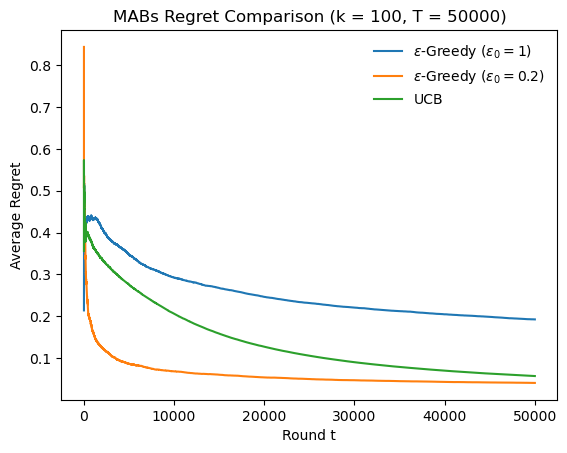

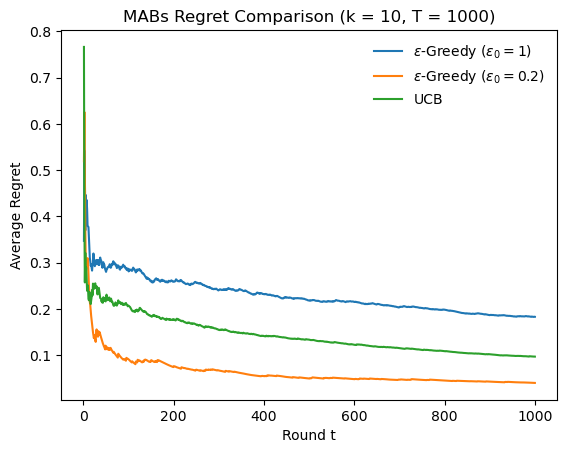

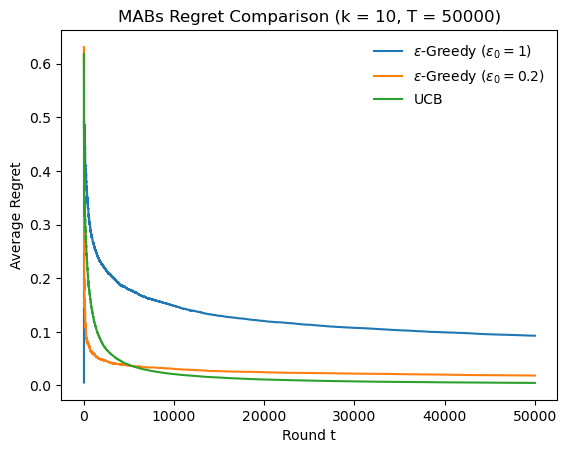

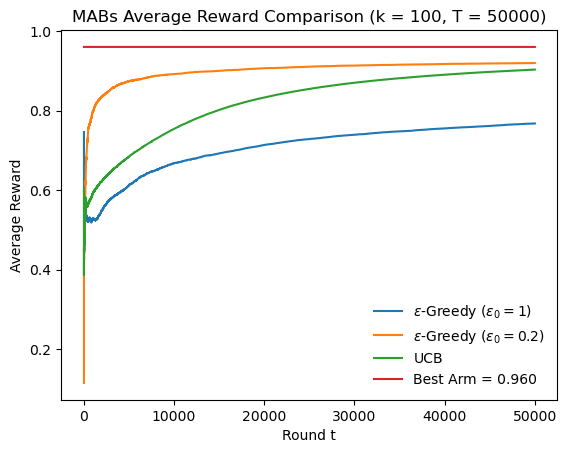

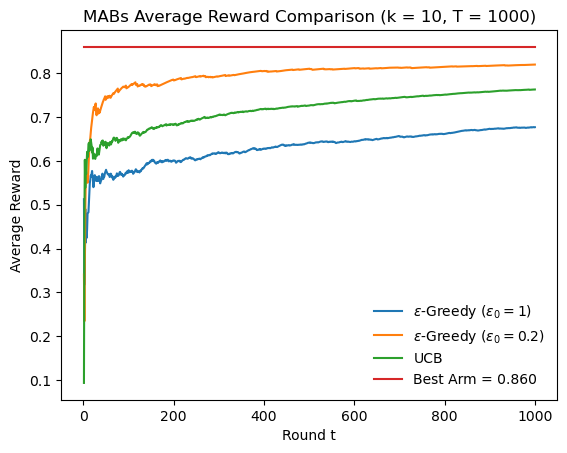

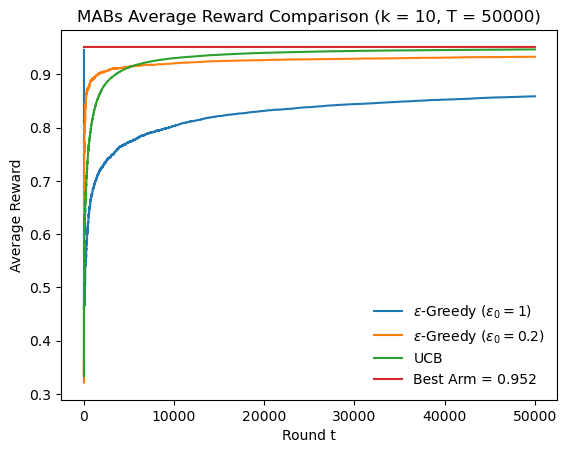

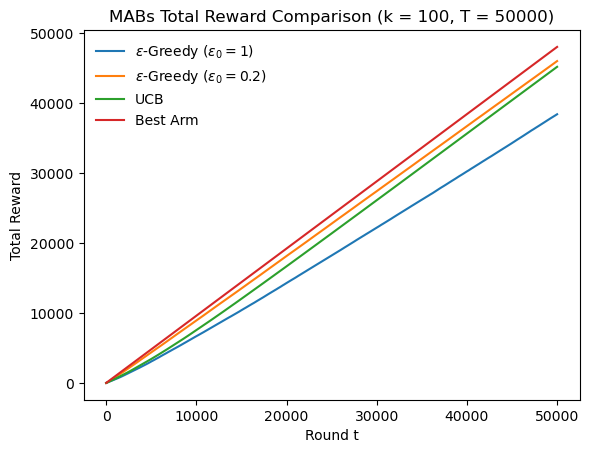

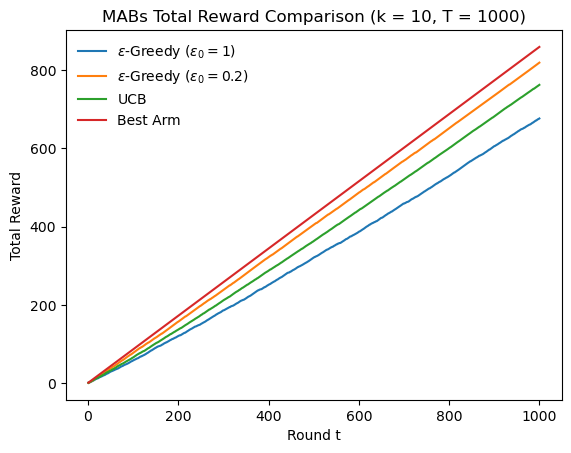

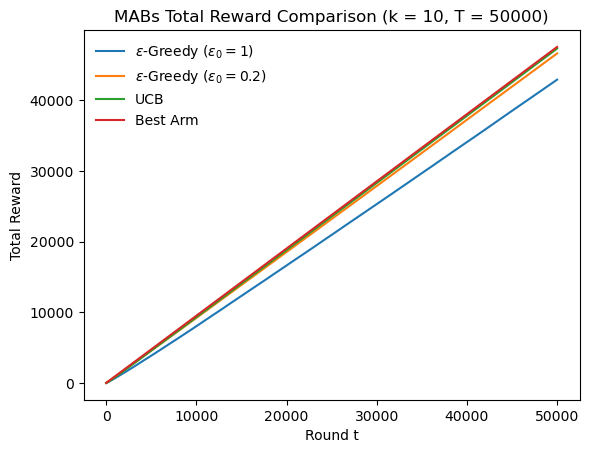

In [144]:
###########################################################
# Load generated figures & clean folder
########################################################### 

if DISPLAY_FIGURES: display_figures()
delete_figures()